In [1]:
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")

In [2]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    PAFNearestNeighbors,
    LowHash,
    HNSW,
    ProductQuantization,
    _NearestNeighbors,
)
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/ecs-user/workspace/kNN-overlap-finder/scripts/../lib


## Parameters


In [3]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20

## Load data

In [4]:
npz_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_93_30k/kmer_k16/feature_matrix.npz"
tsv_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_93_30k/kmer_k16/metadata.tsv.gz"
json_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_93_30k/kmer_k16/read_features.json.gz"
paf_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/minimap2/CHM13/IGK/pbsim_ONT_93_30k/alignment.paf.gz"


In [5]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

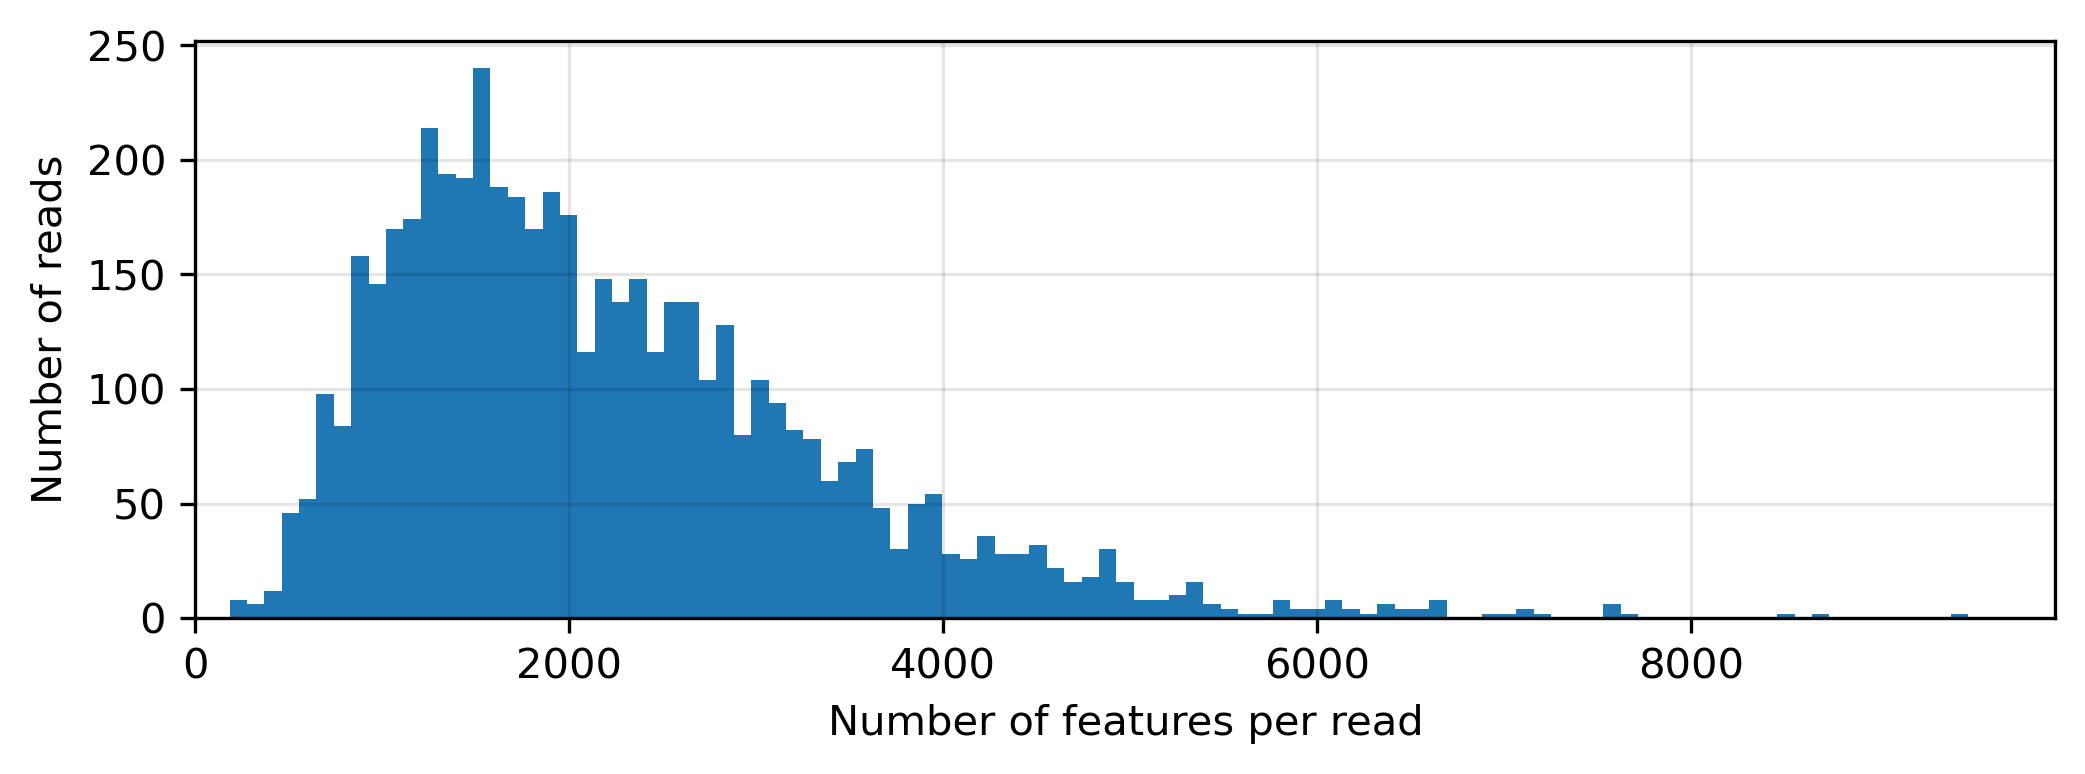

In [6]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.hist([len(x) for x in read_features.values()], bins=100)
ax.set_xlim(left=0)
ax.set_xlabel("Number of features per read")
ax.set_ylabel("Number of reads")
ax.grid(color='k', alpha=0.1)

In [7]:
feature_matrix.shape

(5106, 656109)

In [8]:
feature_matrix.sum() / (feature_matrix.shape[0] * feature_matrix.shape[1])

0.003394533678307444

In [9]:
meta_df

,index,read_id,read_name,read_orientation,read_length,reference_strand,reference_start,reference_end
0,0,0,S1_1,+,11173,+,3818817,3829989
1,1,1,S1_1,-,11173,-,3818817,3829989
2,2,2,S1_2,+,21867,-,3640734,3662730
3,3,3,S1_2,-,21867,+,3640734,3662730
4,4,4,S1_3,+,20113,+,2072903,2093713
...,...,...,...,...,...,...,...,...
5101,5101,5101,S1_2551,-,26580,-,2075897,2102673
5102,5102,5102,S1_2552,+,44667,-,3387382,3432227
5103,5103,5103,S1_2552,-,44667,+,3387382,3432227
5104,5104,5104,S1_2553,+,9939,+,268309,278309


In [10]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

5106

In [11]:
%%time
reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

CPU times: user 6.38 s, sys: 32.1 ms, total: 6.42 s
Wall time: 6.41 s


(5106, 103266, 9866, 2)

## Get nearest neighbours

In [29]:
kw = dict(data=feature_matrix)
max_bucket_size = COVERAGE_DEPTH * 1.5

configs = [
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, 30 dim.)",
        binarize=True,
        tfidf=True,
        dim_reduction=30,
        nearest_neighbor_kw=dict(metric="euclidean"),
        **kw,
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, 50 dim.)",
        binarize=True,
        tfidf=True,
        dim_reduction=50,
        nearest_neighbor_kw=dict(metric="euclidean"),
        **kw,
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, 100 dim.)",
        binarize=True,
        tfidf=True,
        dim_reduction=100,
        nearest_neighbor_kw=dict(metric="euclidean"),
        **kw,
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, 200 dim.)",
        binarize=True,
        tfidf=True,
        dim_reduction=200,
        nearest_neighbor_kw=dict(metric="euclidean"),
        **kw,
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, 500 dim.)",
        binarize=True,
        tfidf=True,
        dim_reduction=500,
        nearest_neighbor_kw=dict(metric="euclidean"),
        **kw,
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        description="Exact Euclidean (IDF, 1000 dim.)",
        binarize=True,
        tfidf=True,
        dim_reduction=500,
        nearest_neighbor_kw=dict(metric="euclidean"),
        **kw,
    ),
]

In [30]:
for i, config in enumerate(configs):
    print(i, config, sep='\t')

0	NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, description='Exact Euclidean (IDF, 30 dim.)', binarize=True, tfidf=True, dim_reduction=30, _elapsed_time=None)
1	NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, description='Exact Euclidean (IDF, 50 dim.)', binarize=True, tfidf=True, dim_reduction=50, _elapsed_time=None)
2	NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, description='Exact Euclidean (IDF, 100 dim.)', binarize=True, tfidf=True, dim_reduction=100, _elapsed_time=None)
3	NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, description='Exact Euclidean (IDF, 200 dim.)', binarize=True, tfidf=True, dim_reduction=200, _elapsed_time=None)
4	NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, description='Exact Euclidean (IDF, 500 dim.)', binarize=True, tfidf=True, dim_reduction=500, _elapsed_time=None)
5	NearestNeighborsConfig

In [31]:
%%time

max_n_neighbors = COVERAGE_DEPTH
processes = 6

mp_compute_nearest_neighbors(data=feature_matrix, configs=configs, n_neighbors=max_n_neighbors, 
                            processes=processes)

Evaluating 6 configs using 6 processes.
321450      Binarization.Binarization.Binarization.Binarization.



Binarization.Binarization.

TF-IDF transform.
TF-IDF transform.
TF-IDF transform.
TF-IDF transform.
TF-IDF transform.
TF-IDF transform.
Dimension reduction.
Dimension reduction.
Dimension reduction.
Dimension reduction.
Dimension reduction.
Dimension reduction.
Elapsed time: 51.23 s
Elapsed time: 85.84 s
Elapsed time: 136.86 s
Elapsed time: 215.19 s
Elapsed time: 545.65 s
Elapsed time: 545.81 s

CPU times: user 1.92 s, sys: 304 ms, total: 2.22 s
Wall time: 9min 7s


## Statistics

In [32]:
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
for i, config in enumerate(configs):
    print(i, end=' ')
    for k in k_values:
        graph = config.get_overlap_graph(n_neighbors=k, read_ids=list(read_features), require_mutual_neighbors=False)
        graphs[i][k] = graph

0 1 2 3 4 5 

In [33]:
df_rows = []
for i, config in enumerate(configs):
    print(i, end=' ')
    for k in k_values:
        graph = graphs[i][k]
        stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        stats = {"config_id": i, "description": config.description, "n_neighbors": k, **stats}
        df_rows.append(stats)
df = pd.DataFrame(df_rows)
df['label'] = df['config_id'].map(str) + " " + df['description']
df['connected_fraction'] = 1 - df['singleton_fraction']

0 1 2 3 4 5 

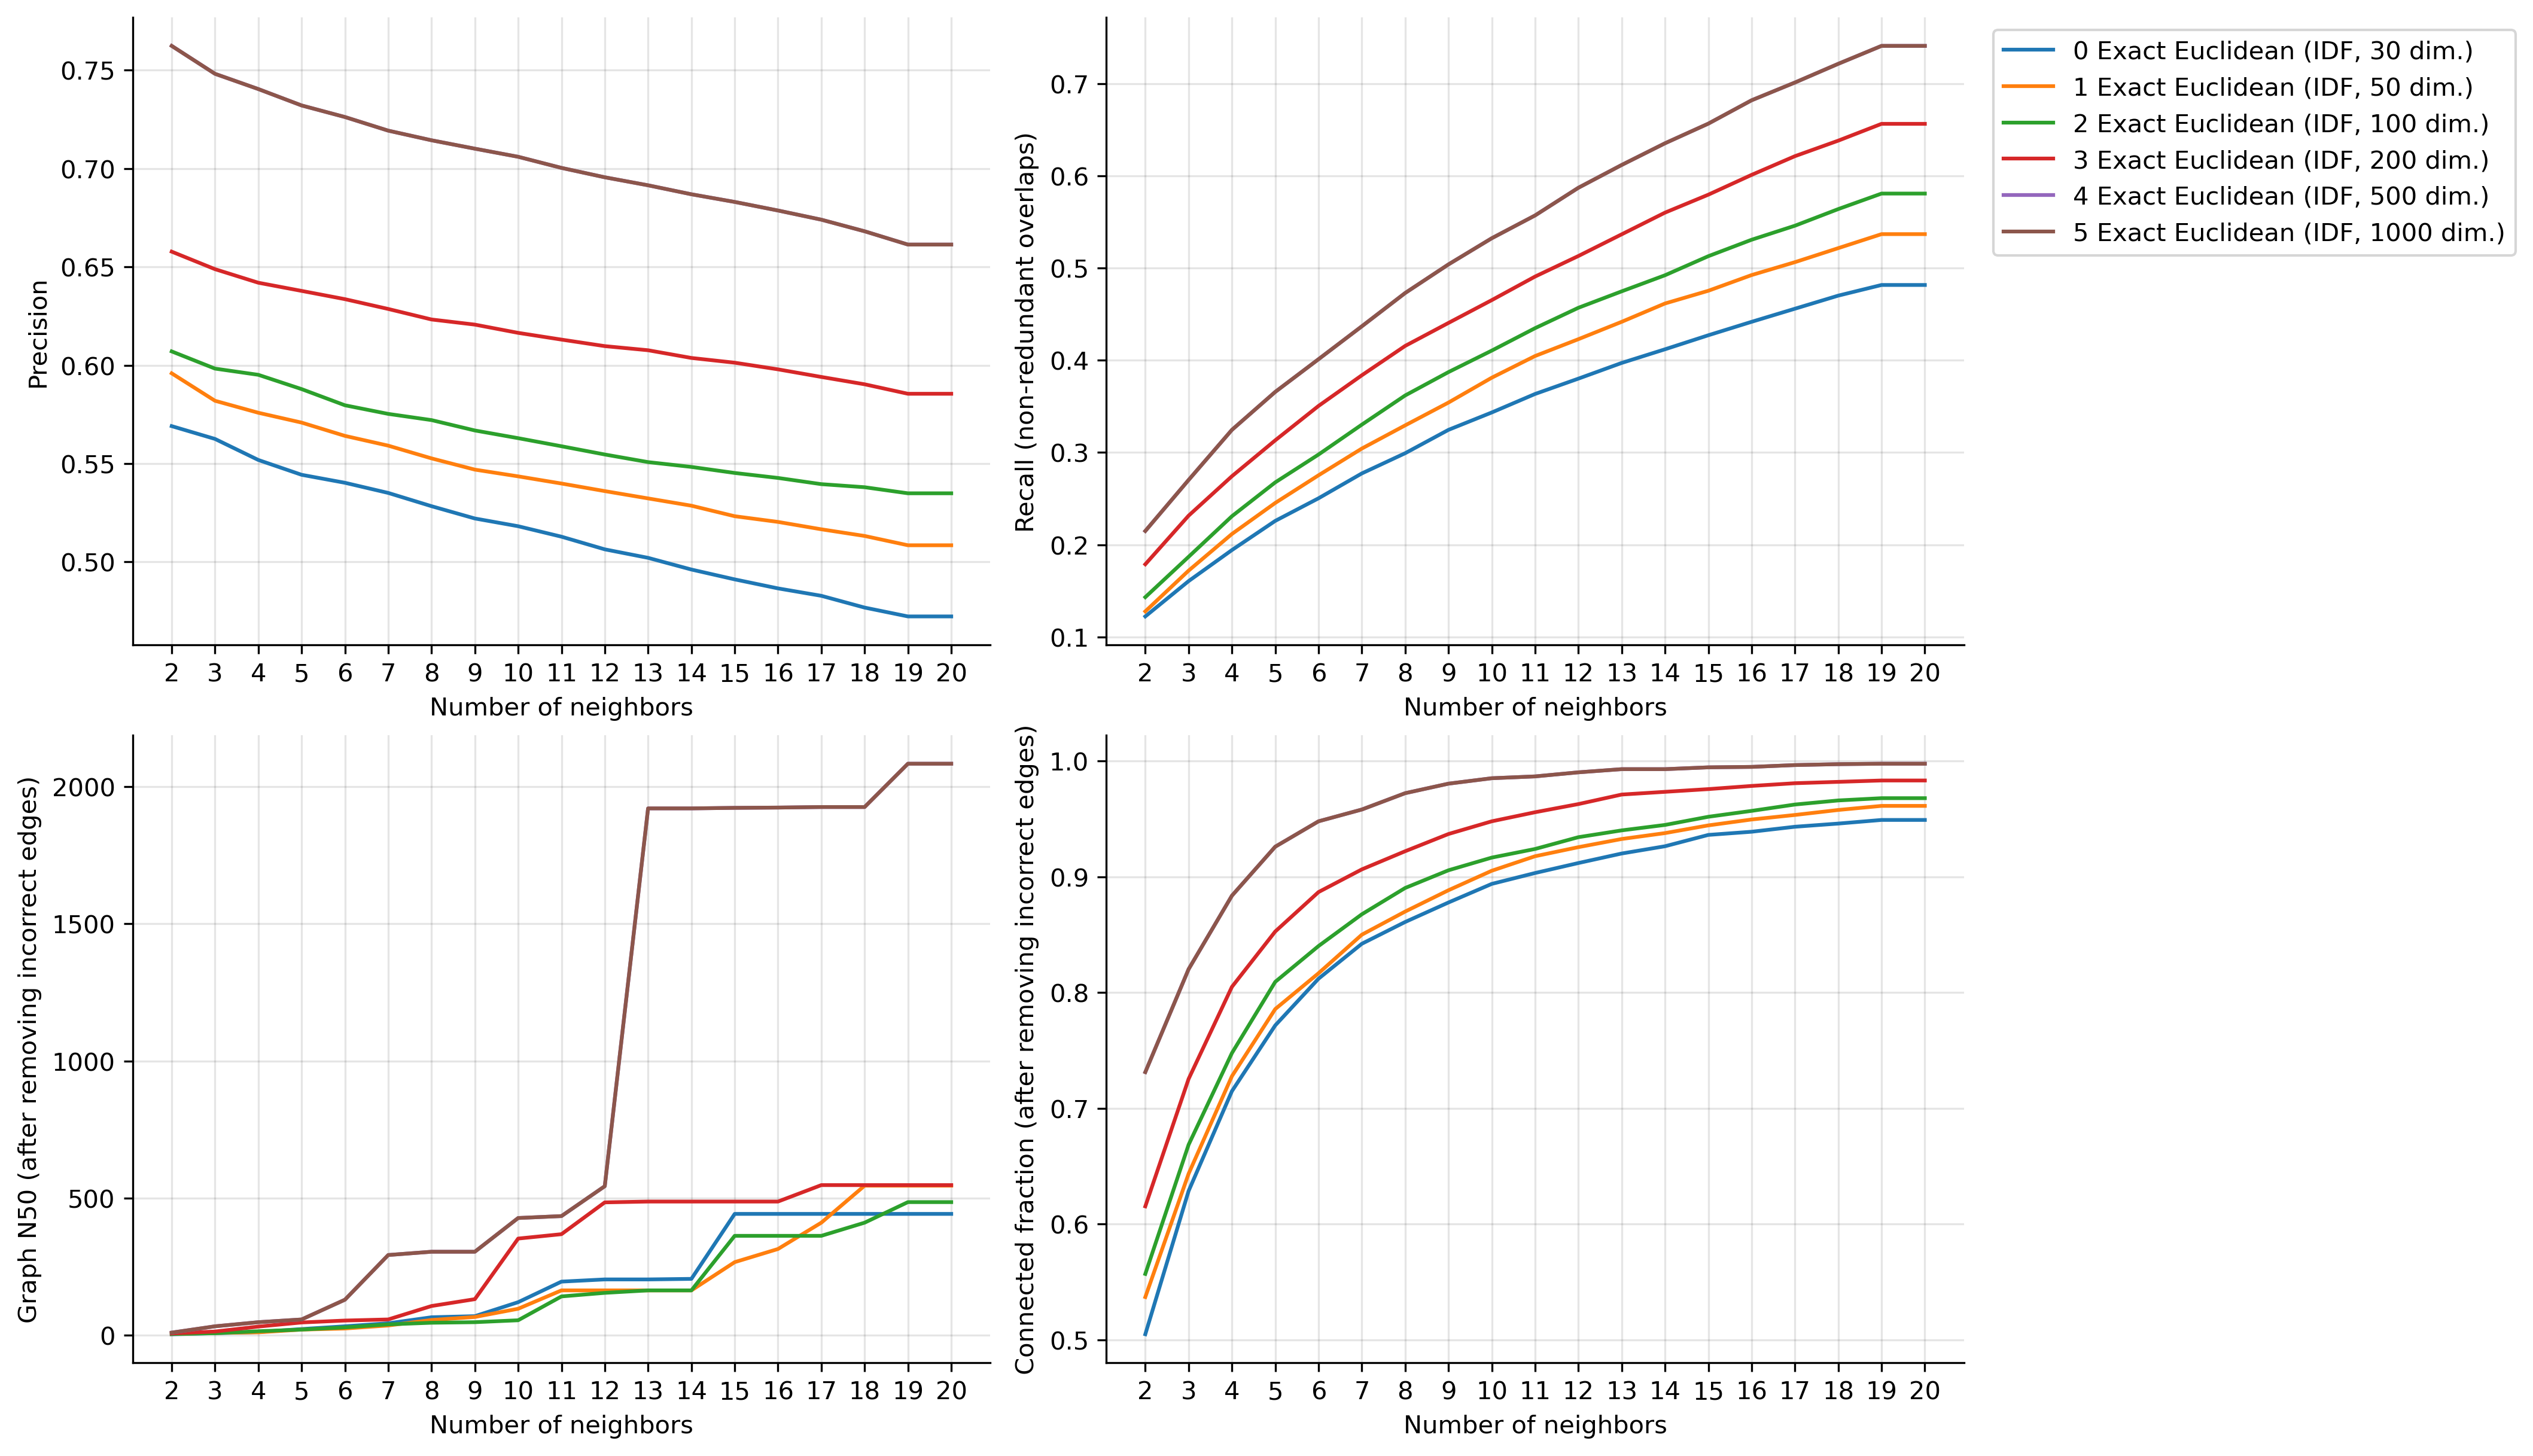

In [34]:
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(configs) <= 10:
    palette = "tab10"
elif len(configs) <= 20:
    palette = 'tab20'
else:
    palette = 'rainbow'

fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'label'
    g = seaborn.lineplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=palette)
    ax.set_xticks(k_values)
    ax.set_xlabel("Number of neighbors")
    ax.set_ylabel(y_labels[y])
    ax.grid(axis='both', color='k', alpha=0.1)

    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    else:
        ax.get_legend().remove()

    ax.spines[['top', 'right']].set_visible(False)

## Graph visualisation

In [35]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)

    for fig, config in zip(figures, configs):
        fig.suptitle(str(config), ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

In [36]:
%%time
k6_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)

NameError: name 'threads' is not defined

In [37]:
%%time
k12_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k12_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)

NameError: name 'threads' is not defined